## Analyse du panier de la ménagère (market basket analysis)


L'objectif de ce projet est d'analyser 7501 tickets de caisse et d'en extraire des règles d'association. 

En exposant les produits achetés ensemble on permettra au gérant du magasin de mieux organiser ces rayons de manière à provoquer plus d'achat.

In [220]:
# TODO : Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Load data

In [161]:
# TODO : Load file and explore the dataset
store = pd.read_csv('input/store_data.csv', header=None)
store.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Chaque ligne/observation du dataset correspond à un caddie.
- On ne tient compte que de la présence des produits mais pas de leur quantité.

On extrait les transactions, ensuite on les stocks dans une liste:

In [178]:
transactions = []
store_ceaned = store.fillna(method='ffill', axis='columns')
for id_trans, transaction in store_ceaned.iterrows():
    transactions.append(transaction.unique().tolist())

In [183]:
# impression du premier ticket de caisse
transactions[0] 

['shrimp',
 'almonds',
 'avocado',
 'vegetables mix',
 'green grapes',
 'whole weat flour',
 'yams',
 'cottage cheese',
 'energy drink',
 'tomato juice',
 'low fat yogurt',
 'green tea',
 'honey',
 'salad',
 'mineral water',
 'salmon',
 'antioxydant juice',
 'frozen smoothie',
 'spinach',
 'olive oil']

Combien de produit unique existe-t-il dans ce dataset?

In [180]:
len(set([w for t in transactions for w in t]))

120

Nos quelques 7501 clients ont acheté 120 produits uniques. Si on souhaite mettre en lumière les combinaisons de produits les plus achetés (un antécédent et un conséquent), on va devoir tester 120*119 combinaisons = 14280 combinaisons possibles!

Pour réduire le nombre de règle on fixe un seuil de support et de confiance (respectivement la fréquence d'apparition du produit(ou ensemble de produits) dans les caddis et la probabilité conditionnelle qu'un client achète un produit B sachant qu'il a acheté A)

Construisons une table binaire, avec comme colonnes les 120 produits et ligne les clients.

In [188]:
from mlxtend.preprocessing import TransactionEncoder
encoder = TransactionEncoder().fit(transactions)
onehote = encoder.transform(transactions)

transactions_matrix = pd.DataFrame(onehote, columns=encoder.columns_)

transactions_matrix.head(2)

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Quels sont les produits les plus achetés?

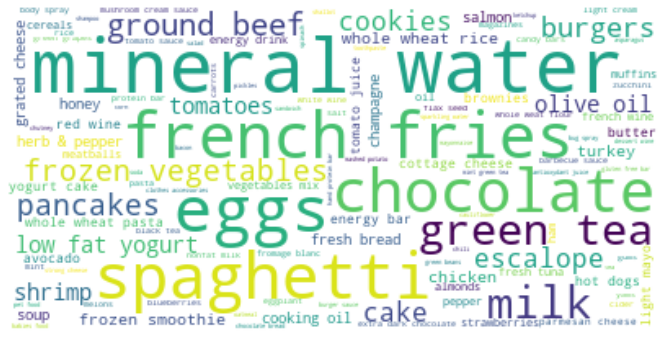

In [217]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(transactions_matrix.mean().sort_values(ascending=False).to_dict())
plt.figure(figsize=(20,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Les produits les plus achetés sont sans trop de surprise l'eau minérale, les oeufs et les frites...

Essayer de confirmer cela, en calculant la fréquence d'apparition de chaque produit et visualisant cela sur un barplot.

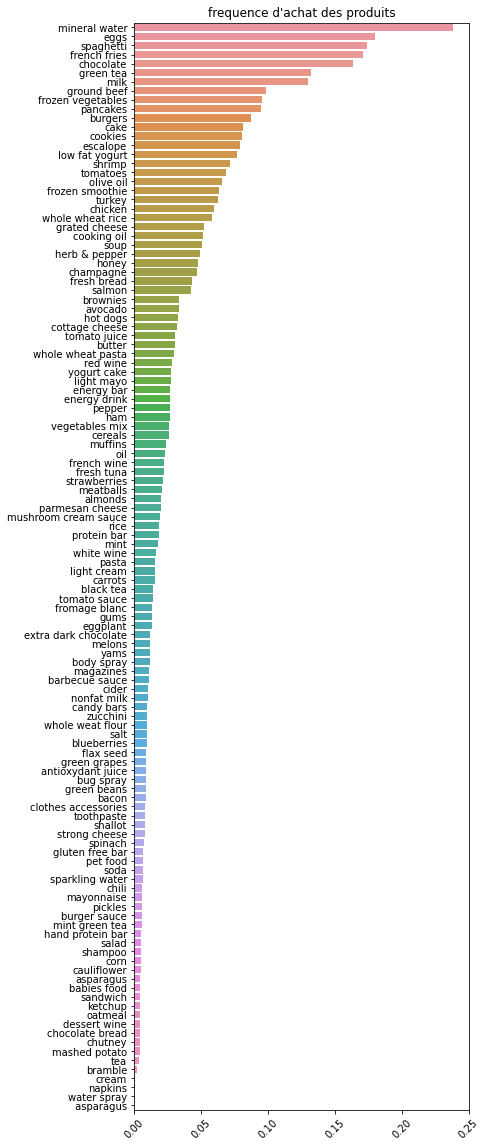

In [226]:
plt.figure(figsize=(6,20))
products_support = transactions_matrix.mean().sort_values(ascending=False)
sns.barplot(x=products_support, y=products_support.index)
plt.xticks(rotation=45)
plt.title("frequence d'achat des produits")
plt.show()

Pour trouver les règles d'associations entre les produits, on utilisera l'algorithme apriori. L'algorithme commence par calculer le support pour chaque produit et élimine tous les produits qui ne respectent pas le seuil minimum de support. Ainsi on évite de construire des règles d'association avec des produits rarement achetés.

On defini un seuil de 4% pour le support et un seuil de 20% pour la confiance

In [207]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

frequent_itemsets = apriori(transactions_matrix, min_support=0.04, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)

In [209]:
rules.sort_values(by='confidence')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(mineral water),(milk),0.238368,0.129583,0.047994,0.201342,1.553774,0.017105,1.089850
2,(mineral water),(eggs),0.238368,0.179709,0.050927,0.213647,1.188845,0.008090,1.043158
0,(mineral water),(chocolate),0.238368,0.163845,0.052660,0.220917,1.348332,0.013604,1.073256
7,(mineral water),(spaghetti),0.238368,0.174110,0.059725,0.250559,1.439085,0.018223,1.102008
3,(eggs),(mineral water),0.179709,0.238368,0.050927,0.283383,1.188845,0.008090,1.062815
1,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,0.013604,1.122357
8,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,0.018223,1.159314
6,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,0.017105,1.209650
4,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401


In [191]:
def get_recommendations(itemset):
    recommendations = rules[rules.antecedents==set({itemset})].sort_values(by='confidence', ascending=False)\
                                                .consequents.to_list()

    return [list(r)[0] for r in recommendations]

In [198]:
item = 'pancakes'
print(f'poeple who bought {item} also bought the following items:\n{get_recommendations(item)}')

poeple who bought pancakes also bought the following items:
['mineral water']
